In [220]:
import nltk
# from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag, pos_tag_sents, word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from collections import defaultdict
import nibabel as nb
import cortex
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [221]:
log_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/Log/'
model_name = 'subject_2_both_layer_norm'
captions_path = f'{log_dir}/{model_name}/eval_out/output_captions_25.npy'
attn_path = f'{log_dir}/{model_name}/eval_out/attention_scores_25.npy'
tokenizer = f'{log_dir}/{model_name}/eval_out/tokenizer.json'

In [332]:
"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))

groups_lh_0 = groups_lh[0]
groups_rh_0 = groups_rh[0]

groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.03
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


In [223]:
def load(fname):
    return np.squeeze(np.load(open(fname, 'rb')), axis=-1)

# def remove_pad(cap: str):
#     cap = cap.split(" ")
#     xs = [x for x in cap if x != '<pad>' and x != '<end>']
#     return " ".join(xs)
def remove_pad(cap: str):
    cap = cap.split(" ")
    cap = [x for x in cap if x != '<pad>']
    cap = [x if x != '<end>' else 'end' for x in cap]
    cap = [x if x != '<unk>' else 'unk' for x in cap]
    return " ".join(cap)

def rank_transform(data):
    return np.log(data)

def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents

def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

In [224]:
X = load(captions_path)
print(X.shape)
X_attn = load(attn_path)
print(X_attn.shape)

tok = tf.keras.preprocessing.text.tokenizer_from_json(open(tokenizer, 'r').read())

(515, 15)
(515, 15, 360)


In [225]:
captions = tok.sequences_to_texts(X)

In [226]:
s = " "
for c in captions:
    s += c

tokenized_words = nltk.tokenize.word_tokenize(s)
fdist = nltk.probability.FreqDist(tokenized_words)
print(fdist.most_common(5))

[('<', 2794), ('>', 2794), ('pad', 2282), ('a', 1254), ('end', 510)]


NOUN 1997
VERB 547
ADJ 432
DET 1373


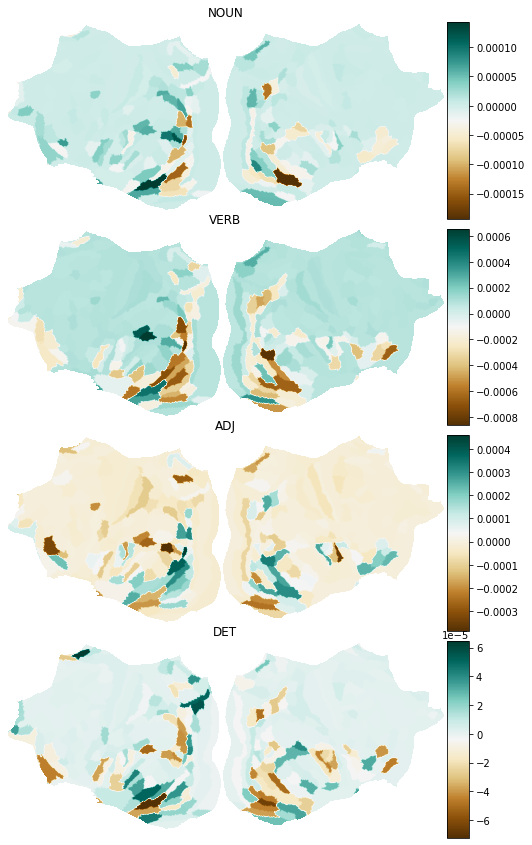

In [376]:
def tagging(captions):
    captions_clean = [remove_pad(i) for i in captions]
    tagged_captions = nltk.pos_tag_sents([word_tokenize(i) for i in captions_clean], tagset = 'universal')
    return tagged_captions

def tag_pos(captions, attention_scores):
    tc = tagging(captions)
    tags_dict = defaultdict(list)
    tags = ['NOUN', 'VERB', 'ADJ', 'DET']
    
#     attention_scores -= np.mean(attention_scores, axis=0)
        
    for t in tags:
        for i, sent in enumerate(tc):
            for j, word in enumerate(sent):
                if word[1] == t:
                    tags_dict[t].append( (i,j) )
    
    attention_tags = defaultdict(list)
    for t in tags:
        for i, j in tags_dict[t]:
            attention_tags[t].append( attention_scores[i, j, :] )
            
    for t in tags:
        print(t, len(tags_dict[t]))

    overall_mean = np.mean(attention_scores, axis=(0,1))
    """
    overall_mean = []
    for i, cap in enumerate(captions):
        cap = cap.split(" ")
        for j, word in enumerate(cap):
            if cap != '<pad>':
                overall_mean.append(attention_scores[i,j,:])
    overall_mean = np.mean(overall_mean, axis=(0,1))
    """
    
    fig, ax = plt.subplots(nrows=len(tags), ncols=1, figsize=(10,15), sharex=True)
    fig.subplots_adjust(wspace=0, hspace=0.05)
#     plt.suptitle("Attention by word tag")
    attn_by_tag = {}
    for i, t in enumerate(tags):
        attn_tag_i = attention_tags[t]
        attn_tag_i = np.mean(attn_tag_i, axis=0) - overall_mean
        attn_by_tag[t] = attn_tag_i
        
        gc = generate_plot(attn_tag_i)
        im, _ = get_flatmap(gc)
        
        im = ax[i].imshow(im, cmap='BrBG')   # cmaps: BrBG RdBu
        ax[i].axis('off')
        ax[i].set_title(t)
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
#     plt.savefig("/home/hpcgies1/Masters-Thesis/AttemptFour/Plots/attn_by_tag.png", bbox_inches='tight')
    return attn_by_tag

attn_by_tag = tag_pos(captions, X_attn)
plt.show()


In [219]:
df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
def idx_to_region(idx: int):
    """
    idx: int [0, 360)
    """
    return df_regions.iloc[idx].regionLongName, df_regions.iloc[idx].regionName

    
for t in ['NOUN', 'VERB', 'ADJ', 'DET']:
    for i in np.argsort(attn_by_tag[t])[::-1][:5]:
        print(idx_to_region(i)[0])
    print("")

Medial_Superior_Temporal_Area_L
Area_TF_L
Area_TemporoParietoOccipital_Junction_3_L
Area_TemporoParietoOccipital_Junction_2_L
Middle_Temporal_Area_L

Area_TF_L
Medial_Superior_Temporal_Area_L
Area_TemporoParietoOccipital_Junction_2_L
Ventral_Visual_Complex_R
Superior_Temporal_Visual_Area_L

Area_V4t_L
Area_PH_L
Fusiform_Face_Complex_L
Area_PGp_L
Area_PH_R

Area_Posterior_24_prime_L
Sixth_Visual_Area_L
Area_TE2_anterior_L
Dorsal_Transitional_Visual_Area_L
Entorhinal_Cortex_L



(15, 360)
(15, 360)
(515, 15, 360)


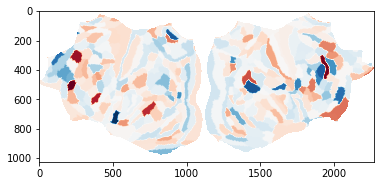

1.0


In [150]:
""" Across words and trials """
mean_ = np.mean(X_attn, axis=0)
std_ = np.std(X_attn, axis=0)
print(mean_.shape)
print(std_.shape)
z_attn = (X_attn - mean_) / std_
print(z_attn.shape)

# interesting idx: 55

fig = plt.figure()
xx = np.mean(z_attn, axis=(0,1))
plt.imshow(get_flatmap(generate_plot(xx))[0], cmap='RdBu')
# plt.imshow(get_flatmap(generate_plot(z_attn[190,0]))[0])
plt.show()
print(np.std(z_attn[:,0]))

""" Across trials """
x_attn_trials = np.mean(X_attn, axis=0)
print(x_attn_trials.shape)

z_attn_trials = (x_attn_trials - np.mean(x_attn_trials, axis=0)) / np.std(x_attn_trials, axis=0)
print(z_attn_trials.shape)

fig = plt.figure()
z_attn_trials_mean = np.mean(z_attn_trials, axis=0)
# z_attn_trials = z_attn_trials[14]
plt.imshow(get_flatmap(generate_plot(z_attn_trials_mean))[0], cmap='RdBu')
plt.show()

In [368]:
x = np.mean(X_attn, axis=(0,1))

In [241]:
all_betas_sub2 = np.load(open("/home/hpcgies1/rds/hpc-work/NIC/Data/subj02/betas_averaged/all_betas.npy", 'rb'))

In [319]:
sub2_cond = pd.read_csv('/home/hpcgies1/Masters-Thesis/AttemptFour/TrainData/subj02_conditions2.csv')
idx = sub2_cond.index
sub2_test = sub2_cond['is_test'] == 1
idx = idx[sub2_test].values
print(len(idx))

idx_train = sub2_cond['is_shared'] == 0
idx_train = sub2_cond.index[idx_train].values
print(len(idx_train))

515
9000


In [320]:
test_betas_sub2 = all_betas_sub2[idx, :]
print(test_betas_sub2.shape)
train_betas_sub2 = all_betas_sub2[idx_train]
print(train_betas_sub2.shape)

(327684,)


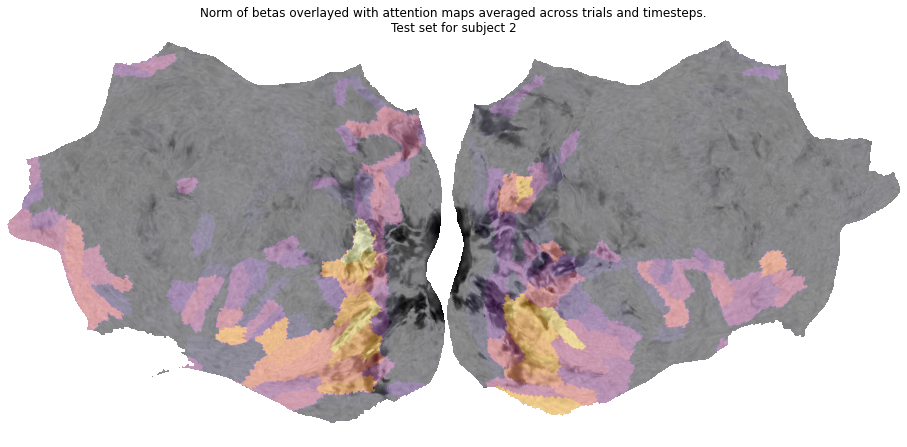

In [369]:
def generate_plot_temp(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

def euclid_norm(x):
    return np.sqrt(np.sum(np.power(x, 2), axis=0))

def gen_plot(data_raw):
    print(data_raw.shape)
    data_raw[groups_lh_0] = np.NaN
    data_raw[groups_rh_0 + (327684//2)] = np.NaN
    return data_raw

fig = plt.figure(figsize=(16,9))

# plt.imshow(get_flatmap( gen_plot(np.mean(test_betas_sub2, axis=0)) )[0], cmap='Greys', alpha=1)
plt.imshow(get_flatmap( gen_plot(euclid_norm(test_betas_sub2)) )[0], cmap='Greys', alpha=1)
plt.imshow(get_flatmap(generate_plot(x))[0], cmap='inferno', alpha = 0.4)

plt.axis('off')
plt.title("Norm of betas overlayed with attention maps averaged across trials and timesteps.\nTest set for subject 2")
# plt.savefig("/home/hpcgies1/Masters-Thesis/AttemptFour/Plots/overlay_norm_attn_test.png", bbox_inches='tight')
plt.show()

(327684,)
(327684,)


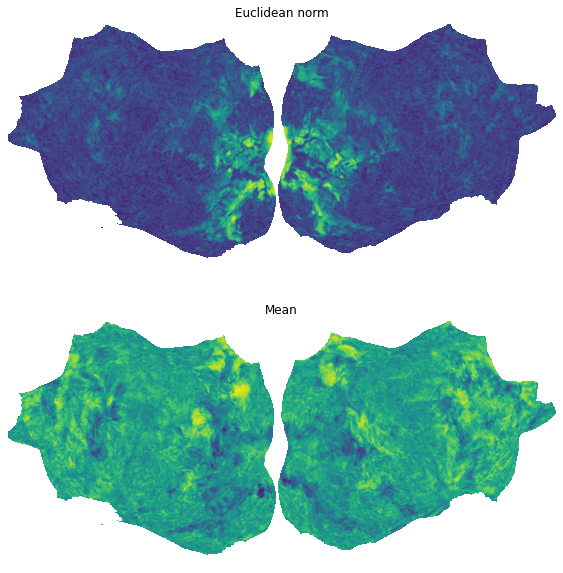

In [372]:
fig, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].imshow(get_flatmap( gen_plot(euclid_norm(test_betas_sub2)) )[0], cmap='viridis', alpha=1)
ax[0].axis('off')
ax[0].set_title("Euclidean norm")

ax[1].imshow(get_flatmap( gen_plot(np.mean(test_betas_sub2, axis=0)) )[0], cmap='viridis', alpha=1)
ax[1].axis('off')
ax[1].set_title("Mean")

# plt.title("")
plt.savefig("/home/hpcgies1/Masters-Thesis/AttemptFour/Plots/diff_norms_test.png", bbox_inches='tight')
plt.show()